# Aim of the Project

**We aim to analyze the growth and market dominance of major players in the used-car resale market (Cars24, CarWale, Spinny, etc.), using exploratory data analysis and predictive modeling. This analysis will provide insights into revenue trends, market share distribution, customer engagement, and vehicle lifecycle to support potential investors or new entrants assessing market viability.**

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from datetime import datetime
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

Load and undderstand the data

 Original data


We have  6437  number of Rows in our Dataset
We have  19  number of Columns in our Dataset


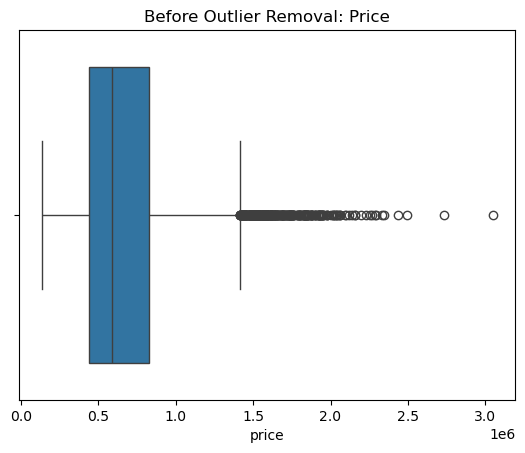


- Column: price
   - Z-score Threshold: 3
   - Outliers Removed: 116
   - Remaining Rows  : 6306


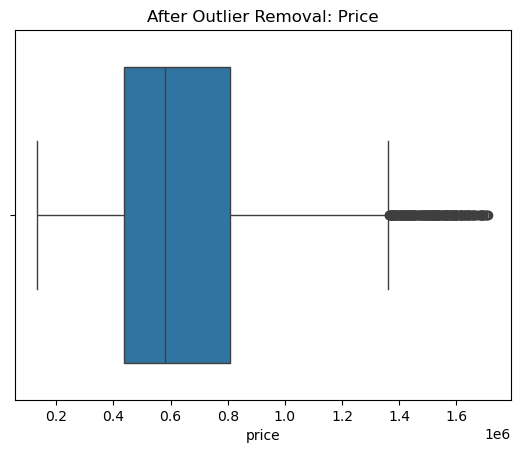

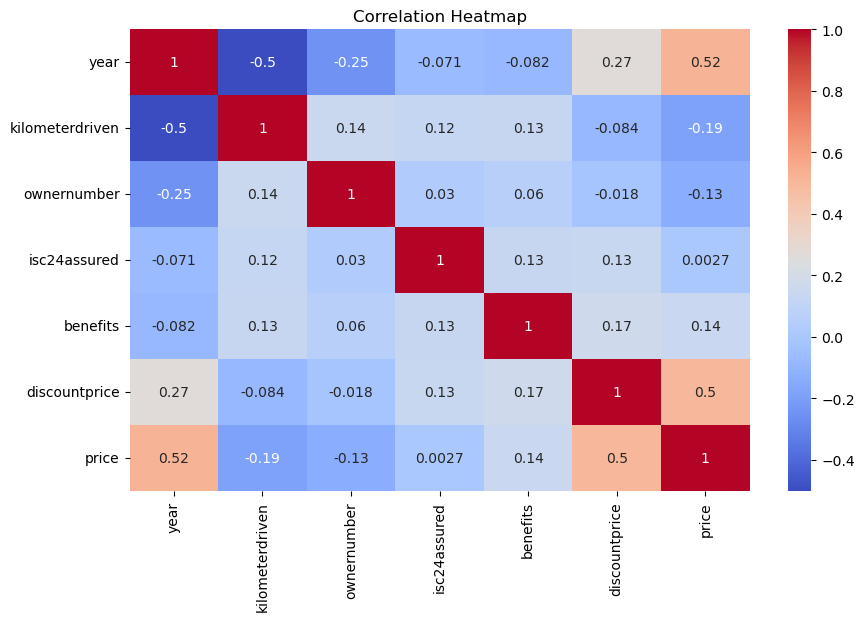

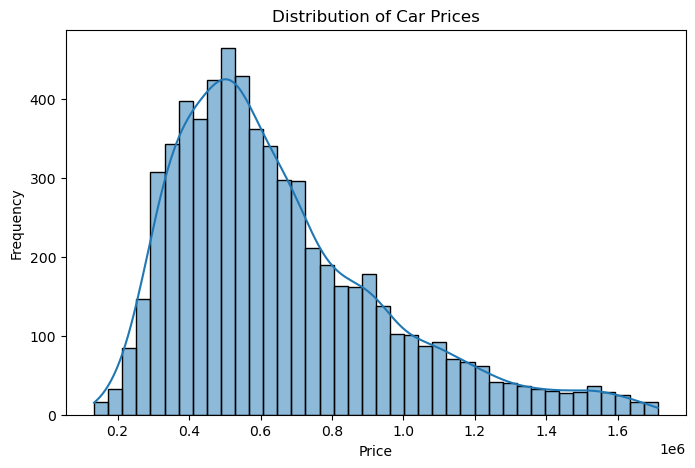

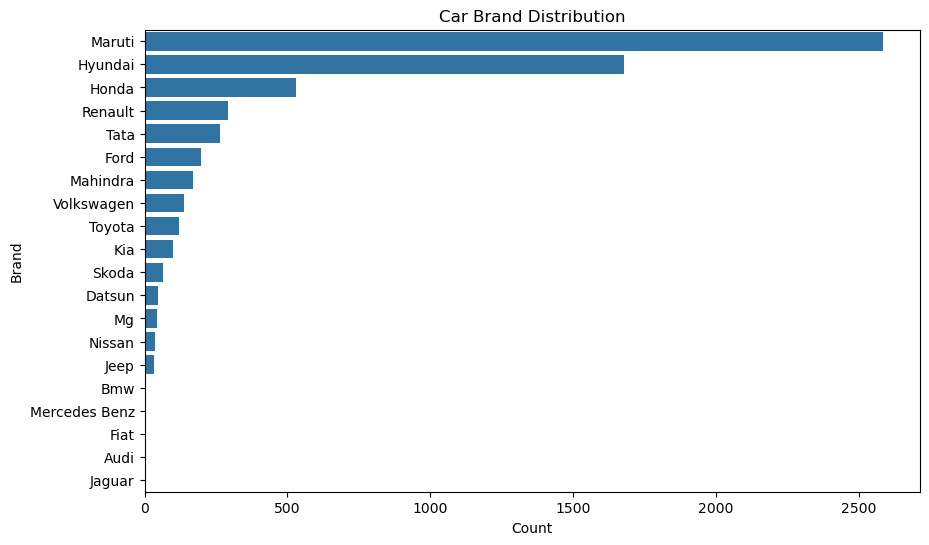

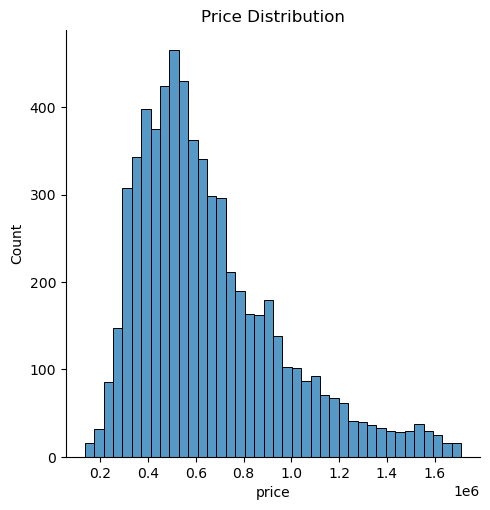

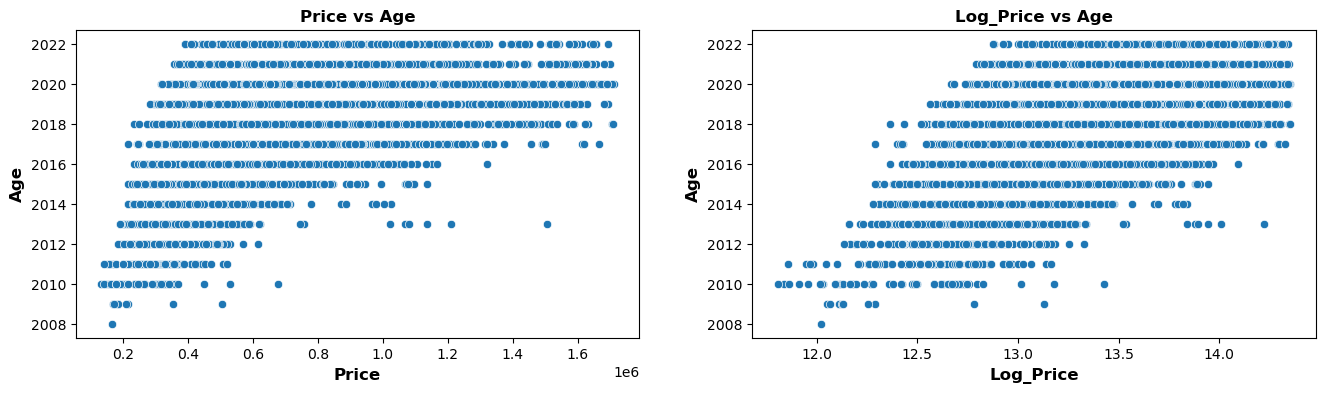



Linear Regression:
	MSE: 5513593120.65
	MAE: 53442.65
	R2 Score: 0.9398

Random Forest:
	MSE: 498501.83
	MAE: 207.05
	R2 Score: 1.0000

KNN Regressor:
	MSE: 14351323888.74
	MAE: 80252.09
	R2 Score: 0.8432

XGBoost Regressor:
	MSE: 19540019.86
	MAE: 1933.91
	R2 Score: 0.9998



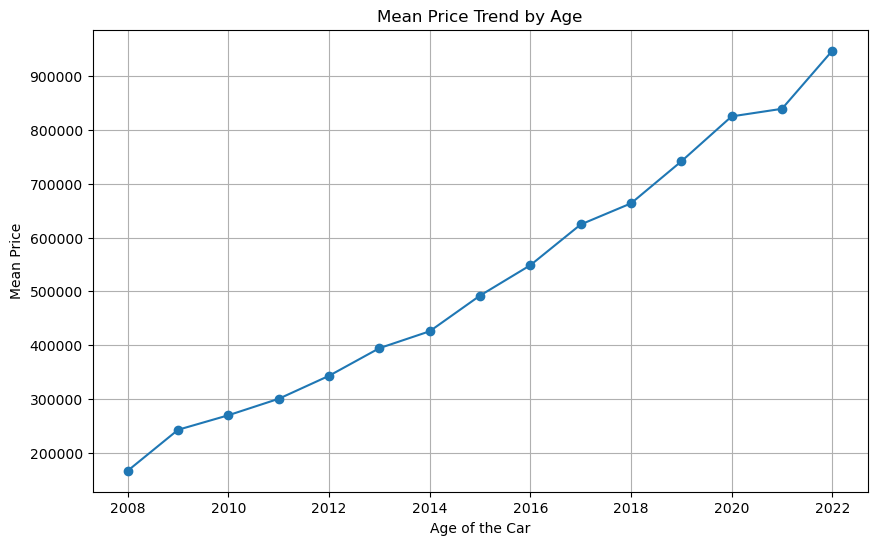

In [ ]:
def Cars24_pred():
    try:
        # Load the dataset
        print("Load and undderstand the data")
        df_original = pd.read_csv("cars24_20221210.csv")

        # Make a copy to preserve original data
        print("\n Original data")
        df = df_original.copy()

        df.head()

        print("\n")
        df.describe()

        print ("We have ",df.shape[0]," number of Rows in our Dataset")
        print ("We have ",df.shape[1]," number of Columns in our Dataset")

        # checking null values
        null_counts = df.isnull().sum()
        null_counts[null_counts > 0]

        # Fill missing 'transmission' and 'bodytype' with mode
        df['transmission'].fillna(df['transmission'].mode()[0], inplace=True)
        df['bodytype'].fillna(df['bodytype'].mode()[0], inplace=True)

        df.duplicated().sum()
        df.drop_duplicates(inplace=True)

        # These may not be useful for ML modeling
        df.drop(['url', 'createdDate', 'storename'], axis=1, inplace=True)

        # Replace negative discounts with 0 (if required)
        df['discountprice'] = df['discountprice'].apply(lambda x: x if x >= 0 else 0)

        # Before removing outliers
        sns.boxplot(x=df['price'])
        plt.title("Before Outlier Removal: Price")
        plt.show()  

        def remove_outliers_zscore(df, column, threshold=3):
            df = df.copy()
            df[f'{column}_Zscore'] = np.abs(zscore(df[column]))
    
            outliers = df[df[f'{column}_Zscore'] > threshold]
            cleaned_df = df[df[f'{column}_Zscore'] <= threshold].drop(columns=[f'{column}_Zscore'])

            print(f"\n- Column: {column}")
            print(f"   - Z-score Threshold: {threshold}")
            print(f"   - Outliers Removed: {outliers.shape[0]}")
            print(f"   - Remaining Rows  : {cleaned_df.shape[0]}")
    
            return cleaned_df

        df = remove_outliers_zscore(df, 'price')

        # After removing outliers
        sns.boxplot(x=df['price'])
        plt.title("After Outlier Removal: Price")
        plt.show()

        # Plot correlations
        plt.figure(figsize=(10, 6))
        sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
        plt.title("Correlation Heatmap")
        plt.show()


        plt.figure(figsize=(8, 5))
        sns.histplot(df['price'], kde=True)
        plt.title('Distribution of Car Prices')
        plt.xlabel('Price')
        plt.ylabel('Frequency')
        plt.show()

        plt.figure(figsize=(10, 6))
        sns.countplot(y='make', data=df, order=df['make'].value_counts().index)
        plt.title('Car Brand Distribution')
        plt.xlabel('Count')
        plt.ylabel('Brand')
        plt.show()

        sns.displot(df['price'])
        plt.title('Price Distribution')

        log_price = np.log(df['price'])
        df['log_price'] = log_price
        df.head()

        plt.figure(figsize=(16,4))
        plt.subplot(1,2,1)
        sns.scatterplot(data=df,x='price',y='year',palette='rocket')
        plt.title('Price vs Age',size=12,color='black',weight='bold')
        plt.xlabel('Price',size=12,color='black',weight='bold')
        plt.ylabel('Age',size=12,color='black',weight='bold')

        plt.subplot(1,2,2)
        sns.scatterplot(data=df,x='log_price',y='year',palette='rocket')
        plt.title('Log_Price vs Age',size=12,color='black',weight='bold')
        plt.xlabel('Log_Price',size=12,color='black',weight='bold')
        plt.ylabel('Age',size=12,color='black',weight='bold')
        plt.show()

        plt.figure(figsize=(10, 6))
        df.groupby('year')['price'].mean().plot(kind='line', marker='o')
        plt.title('Mean Price Trend by Age')
        plt.xlabel('Age of the Car')
        plt.ylabel('Mean Price')
        plt.grid(True)


        # Get the current date and time
        current_date_time = datetime.now()
        # Extract the year attribute
        current_year = current_date_time.year


        #Feature Engineering
        #Car Age
        df['car_age'] = current_year - df['year']

        #Price per km driven
        df['price_per_km'] = df['price'] / df['kilometerdriven']

        #First owner binary feature
        df['is_1st_owner'] = (df['ownernumber'] == 1).astype(int)

        #Transmission type binary
        df['is_automatic'] = (df['transmission'] == 'Automatic').astype(int)

        #Label encoding for objective column
        le = LabelEncoder()
        label_cols = ['name', 'make','model', 'city', 'fueltype','transmission','bodytype','registrationcity','registrationstate']
        for col in label_cols:
            df[col] = le.fit_transform(df[col])

        X = df.drop('price', axis=1)
        y = df['price']
    
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)

        # Define models
        models = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(random_state=42),
            'KNN Regressor': Pipeline([
                ('scaler', StandardScaler()),
                ('knn', KNeighborsRegressor())
            ]),
            'XGBoost Regressor': XGBRegressor(random_state=42, verbosity=0)
        }

        # Store results
        results = {}

        # Train and evaluate models
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            results[name] = {
                'MSE': mse,
                'MAE': mae,
                'R2 Score': r2
            }

        # Print results
        for model_name, scores in results.items():
            print(f"{model_name}:\n"
                  f"\tMSE: {scores['MSE']:.2f}\n"
                  f"\tMAE: {scores['MAE']:.2f}\n"
                  f"\tR2 Score: {scores['R2 Score']:.4f}\n")




    except FileNotFoundError:
        print("Error")

Cars24_pred()